In [23]:
#Import relevant libraries
%matplotlib inline
%config InlineBackend.figure_format = 'retina' #nicer rendering of plots in retina displays

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import plotly.plotly as py
import plotly.graph_objs as go

import seaborn as sns
sns.set()
pal = sns.hls_palette(10, h=.5)
sns.set_palette(pal)

import re

<h1>Analyzing the Impact of the Affordable Care Act</h1>
<br>
   <br>
</br>

The **Affordable Care Act (ACA)** is the comprehensive health care reform law and its amendments addressing health insurance coverage, health care costs, and preventive care in the United States. In particular, the law established a Health Insurance Marketplace, and allowed all states to opt in to expand their Medicaid program.

The law was enacted in two parts, namely The Patient Protection and Affordable Care Act which was signed on March 23, 2010 by President Barack Obama and amended by the Health Care and Education Reconciliation Act of March 30, 2010. A repeal of the ACA was recently passed by the Congress. 

This analysis aims to visualize metrics that **quantify the impact of the ACA** and expose some interesting findings.

<h2>The <em>Status Quo</em>: Insurance Coverage Before the ACA (1995-2010)</h2>

According to the [source](https://www.kaggle.com/cdc/health-care-access-coverage) of this dataset, the information about health insurance coverage between 1995 to 2010 was compiled from the **US Department of Health and Human Services** and the **US Census Bureau**. More specifically, the data seems to have originated at least in part from the [American Community Survey](https://en.wikipedia.org/wiki/American_Community_Survey).

The dataset contains a feature (a column) labeled "Category" with two distinct values: **Do you have any kind of health care coverage?** and **Adults aged 18-64 who have any kind of health care coverage**. Here we analyze the **former** because it's not limited by the age group. The summary statistics between both sets differ but only slightly, as expected.

The **Figure 1** below shows the trend in the percentage of the surveyed population over the years who responded yes for having any kind of insurance coverage. The data represents the mean per US Census region for each year.

Interestingly, the chart shows the Northeast and Midwest regions reporting coverage about 5% points higher than the West and South. However, this difference may be within the error range of the survey.

In general, there is a small drop of about 2% points in the reported proportion of the population covered by health insurance along the period, with the exception of the US territories which show a much more pronounced change. There was a consistent and noticeable change point in the trend in 2001 for all regions. This may have been associated with macroenomic factors, such as the economic [recession](http://www.nber.org/cycles/cyclesmain.html) of 2001. However, a similar impact is not seen in the data for the deeper recession of 2008. It's also possible that the drop in 2001 may have been caused by a change in the survey methodology, for example.

The national mean of insured population along the entire period was 86%. According to the US Census, the population in 2010 was about 303 million, which amounts to about **43 million people not covered by any type of health insurance**.

In [2]:
#Load the data downloaded from the referred link
pre_ACA = pd.read_csv('Data/HC_access_1995-2010.csv')

In [3]:
#Process data

#Remove % from string values
pre_ACA['Yes'] = pre_ACA.Yes.apply(lambda x: re.sub('%', '', x))
pre_ACA['No'] = pre_ACA.No.apply(lambda x: re.sub('%', '', x))


#Get geolocation
pre_ACA['geolocation'] = pre_ACA['Location 1'].apply(lambda x: x.split('\n')[1].split(','))


#Get latitude from geolocation
pre_ACA['lat'] = pre_ACA.geolocation.apply(lambda x: re.sub('\(', '', x[0]))


#Get longitude from geolocation
def get_long(x):
    return re.sub('\)|\s', '', x[1]) if len(x)>1 else ''

pre_ACA['long'] = pre_ACA.geolocation.apply(lambda x: get_long(x))


#Convert string datatypes to numeric
for col in ['Yes', 'No', 'lat', 'long']:
    pre_ACA[col] = pd.to_numeric(pre_ACA[col])


#Drop redundant columns
pre_ACA = pre_ACA.drop('geolocation', axis=1)
pre_ACA = pre_ACA.drop('Location 1', axis=1)


#Check stats for comparison.
#pre_ACA[pre_ACA.Condition == 'Do you have any kind of health care coverage?'][['Yes', 'No']].describe()
#pre_ACA[pre_ACA.Condition != 'Do you have any kind of health care coverage?'][['Yes', 'No']].describe()

In [4]:
#Select a subset of the data
subset = pre_ACA[(pre_ACA.State.str.contains('Nationwide') == False)\
        & (pre_ACA.Condition == 'Do you have any kind of health care coverage?')] #844 rows


#Drop redundant columns
subset = subset.drop('Category', axis=1)
subset = subset.drop('Condition', axis=1)


#Load file with state codes
state_codes = pd.read_csv('Data/state_codes.csv')
state_codes = state_codes[['code','state']]
state_codes.columns = ['code', 'State']


#Merge state code into dataset
subset= subset.merge(state_codes, how='left', on='State')

In [5]:
#Define lists with US Census regions

Northeast = ['Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 'Rhode Island', 'Vermont', 'Delaware', 
             'New Jersey', 'New York', 'Pennsylvania']

Midwest = ['Illinois', 'Indiana', 'Michigan', 'Ohio', 'Wisconsin', 'Iowa', 'Kansas', 'Minnesota', 'Missouri', 
           'Nebraska', 'North Dakota', 'South Dakota']

South = ['Florida', 'Georgia', 'Maryland', 'North Carolina', 'South Carolina', 'Virginia', 'District of Columbia',
         'West Virginia', 'Alabama', 'Kentucky', 'Mississippi', 'Tennessee', 'Arkansas', 'Louisiana', 
         'Oklahoma', 'Texas']

West = ['Arizona', 'Colorado', 'Idaho', 'Montana', 'Nevada', 'New Mexico', 'Utah', 'Wyoming', 'Alaska', 
        'California', 'Hawaii', 'Oregon', 'Washington']

Territories = ['Puerto Rico', 'Guam', 'Virgin Islands']


#Create series with grouped data per region
northeast = subset[subset.State.isin(Northeast)].groupby(['Year']).Yes.mean()
midwest = subset[subset.State.isin(Midwest)].groupby(['Year']).Yes.mean()
south = subset[subset.State.isin(South)].groupby(['Year']).Yes.mean()
west = subset[subset.State.isin(West)].groupby(['Year']).Yes.mean()
territories = subset[subset.State.isin(Territories)].groupby(['Year']).Yes.mean()

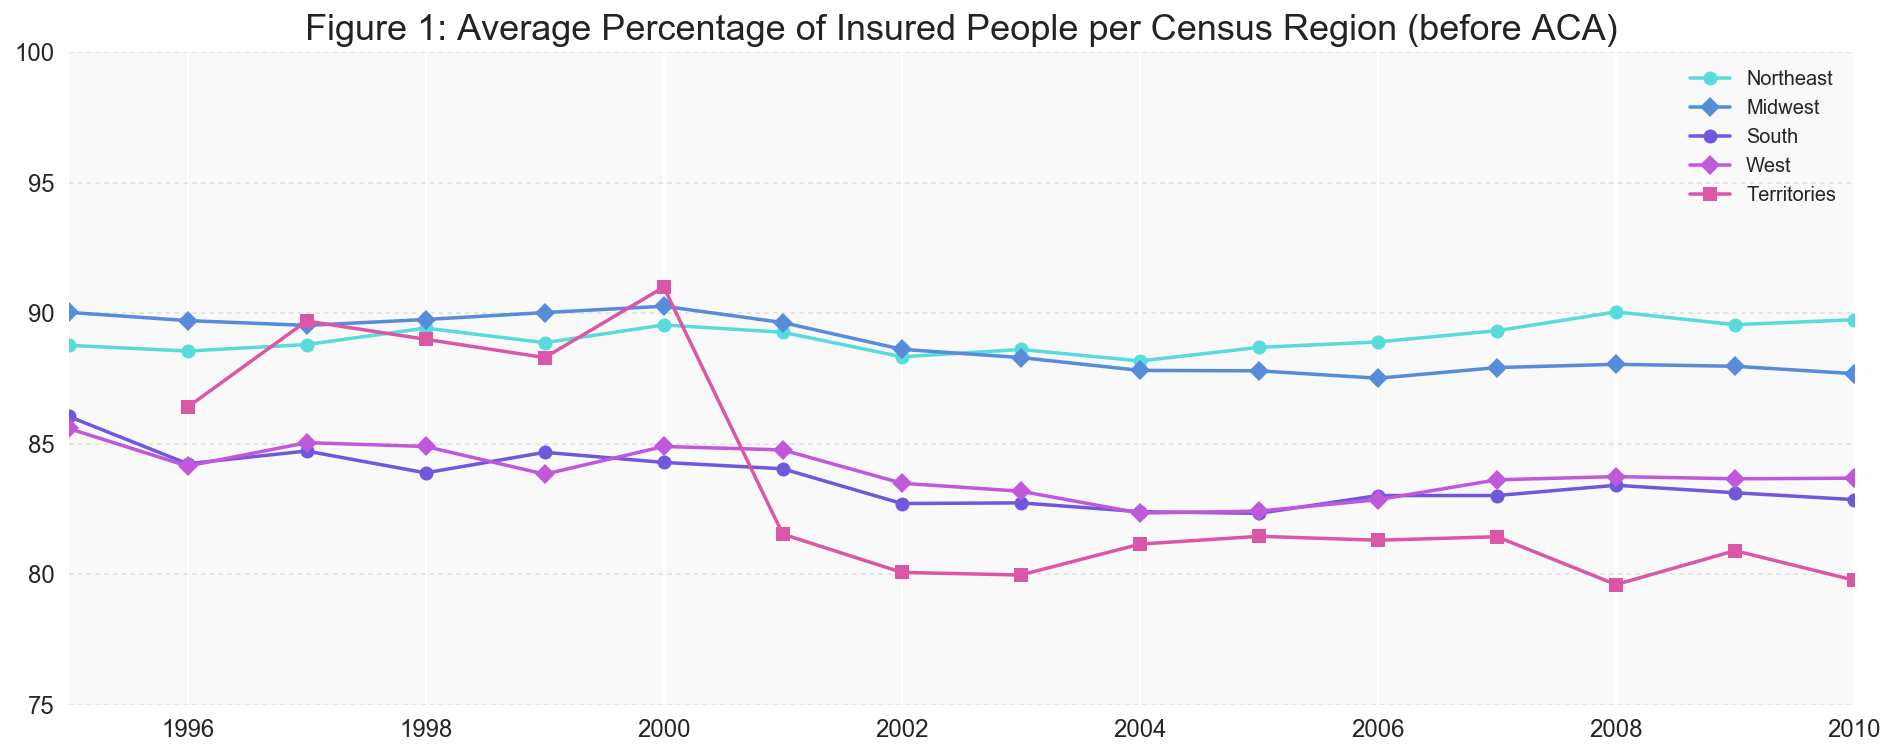

In [6]:
#Create plot with percentage of people who have answered to have some form of insurance (mean per US census region)

fig, ax = plt.subplots(1,1, figsize=(16, 6))

northeast.plot(label='Northeast', marker='o')
midwest.plot(label='Midwest', marker='D')
south.plot(label='South', marker='o')
west.plot(label='West', marker='D')
territories.plot(label='Territories', marker='s')

ax.set_facecolor('#F9F9F9')
ax.grid(color='#E4E4E4', linestyle='dotted', linewidth=1, axis ='y')

plt.ylim(75, 100)
plt.title('Figure 1: Average Percentage of Insured People per Census Region (before ACA)', fontsize=18, color='#232323')
plt.xlabel('')
plt.tick_params(labelsize=12)
plt.legend(loc='upper right');

<h2>The Insurance Landscape in the Years After the ACA (2010-2015)</h2>

The dataset about health insurance coverage from 2010 is not continuous but it contains more detailed features related to estimates of the uninsured population and a breakdown by source of coverage for each state. Details on the source of the data can be found [here](https://www.kaggle.com/hhs/health-insurance).

Let's take a closer look at the uninsured population data, then at the sources of insurance coverage, and finally dive into Medicare and Medicaid data.

In [7]:
#Load the data downloaded from the referred link
post_ACA = pd.read_csv('Data/HC_access_afterACA.csv')

In [8]:
#Process the data

#Remove % from string values
cols = ['Uninsured Rate (2010)', 'Uninsured Rate (2015)','Uninsured Rate Change (2010-2015)'] #% values
for col in cols:
    post_ACA[col] = post_ACA[col].apply(lambda x: re.sub('%', '', x))


#Remove $ from string values
post_ACA['Average Monthly Tax Credit (2016)'] = \
post_ACA['Average Monthly Tax Credit (2016)'].apply(lambda x: x[1:-1])


#Convert string datatypes to numeric
for col in cols:
    post_ACA[col] = pd.to_numeric(post_ACA[col])
    
post_ACA['Average Monthly Tax Credit (2016)'] = pd.to_numeric(post_ACA['Average Monthly Tax Credit (2016)'])


#Remove trailing whitespace from state names
post_ACA.State = post_ACA.State.apply(lambda x: x.rstrip())


#Merge state code into dataset
post_ACA = post_ACA.merge(state_codes, how='left', on='State')


#Create column with the total insured population per state. Assign code for United States.
post_ACA.loc[51:,('code')] = 'US'
post_ACA['insured_pop'] = post_ACA.iloc[:,(5,6,11,13)].sum(axis=1)


#Calculate the proportion of enrollment change per state between 2013 and 2016 from the country's 
#total new enrollments for the period.
post_ACA['medicaid_delta'] = (post_ACA['Medicaid Enrollment Change (2013-2016)']/\
post_ACA['Medicaid Enrollment Change (2013-2016)'][51]) *100


#post_ACA.head()

In [9]:
#EXPLORING DATA ABOUT THE UNINSURED POPULATION

#States with the largest proportion of uninsured population before ACA (2010)
#post_ACA.ix[:,:4].sort_values(by='Uninsured Rate (2010)', ascending = False)[:19]

#Texas still has the highest rate of uninsured population in the country
#post_ACA['Uninsured Rate (2015)'].max() #17%

#All states have shown a drop in uninsured population. Massachusetts had the lowest change in the country...
#and also the lowest rate of uninsured population before and after ACA. Will California follow with SB 562?
#post_ACA[post_ACA['Uninsured Rate (2015)'] < 3]

#States with the largest decreases in uninsured population after ACA (2015)
uninsured_rate = post_ACA.ix[:,[1,2,3,-3]].sort_values(by='Uninsured Rate Change (2010-2015)', ascending = True)[:17]
#uninsured_rate

<h3>The Effect of the ACA in the Proportion of Uninsured Population</h3>

The mean uninsured population rate in the United States in 2010, according to this data source, **was 15.5%**. This is within the range of the number from the previous dataset (about 15% for 2010). This number is reoprted to have dropped to **9.4% in 2015**.

In addition, the data shows:
<br>
</br>
<li style="font-family: arial; font-size: 18px;" markdown="1"><strong>16 million</strong> more people insured by Medicaid between 2013 and 2016</li>
<li style="font-family: arial; font-size: 18px;" markdown="1"><strong>11 million</strong> people insured by the Healthcare Marketplace in 2016</li>
<li style="font-family: arial; font-size: 18px;" markdown="1">an increment of <strong>19 million</strong> in insured individuals between 2010 and 2015.
</li>

Most of the increase in the insured population was **driven by the expansion of Medicaid and the Marketplace** rather than Employer and Medicare, which will be shown later in this analysis.

The **top 5 states with the highest percentage of uninsured population in 2010** (before the ACA), were Texas, Nevada, Florida, Arkansas and Georgia. Except for Nevada, all these states remain among the top 5 in terms of uninsured population, albeit at lower levels. Leading the list, **Texas** had 23.7% uninsured individuals in 2010, and it still had the **highest** uninsured rate in 2015 (17.1%).

**All states have seen a drop in the uninsured rate** after the implementation of the ACA. **Massachusetts** had the **lowest** drop in the uninsured rate (-1.6% points) because the state already had he lowest rate (only 4.4%) before the new law. Could California, still with 8.6% uninsured population in 2015 follow if [SB562](https://leginfo.legislature.ca.gov/faces/billNavClient.xhtml?bill_id=201720180SB562) is approved?

The **Figure 2** below interactively displays information about the states that have seen a decrease in uninsured population at or above the **national average of 6.1%** between 2010 and 2015. 

The political representation of the states shown in the plot is approximately even between the typically "red" and "blue + swing" groups. Except for **Texas, Idaho and South Carolina**, all the other states have opted to expand their Medicaid programs. Therefore, the drop in uninsured rates for these 3 states was driven mostly by people signing up into the Health Insurance Marketplace. This is demonstrated in the next session, where we analyze health insurance by source of coverage.

In [10]:
#Equivalent interactive version
#(0,120,171) - big sky blue; (64, 224, 208) - turquoise blue

trace2010 = go.Bar(
    x=uninsured_rate['code'],
    y=uninsured_rate['Uninsured Rate (2010)'],
    name='2010 - Uninsured Rate',
    marker=dict(
        color='rgb(64, 224, 208)'
    )
)
trace2015 = go.Bar(
    x=uninsured_rate['code'],
    y=uninsured_rate['Uninsured Rate (2015)'],
    name='2015 - Uninsured Rate',
    marker=dict(
        color='rgb(0, 120, 171)'
    )
)
data = [trace2010, trace2015]
layout = go.Layout(
    title='Figure 2: States Showing the Largest Changes in Uninsured Population',
    xaxis=dict(
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Uninsured Population (%)',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    legend=dict(
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='group',
    bargap=0.15,
    bargroupgap=0.1
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='uninsured-pop-drop')

In [11]:
#EXPLORING DATA ABOUT SOURCES OF INSURANCE

#List dataset columns with insured population breakdown by source of insurance
cols = [u'code', u'Employer Health Insurance Coverage (2015)',
       u'Marketplace Health Insurance Coverage (2016)',
       u'Medicaid Enrollment (2016)', u'Medicare Enrollment (2016)',
       u'insured_pop']

#Select data with enrollment per source of insurance. 
insurance_type = post_ACA.ix[:,(cols)]

#Calculate total insured population and share of government coverage for each state.
insurance_type['single_payer'] = insurance_type.ix[:,(3,4)].sum(1)/insurance_type.ix[:,('insured_pop')]
insurance_type['market'] = 1- insurance_type.single_payer

#Breakdown for each source of insurance.
insurance_type['prop_employer'] = \
insurance_type['Employer Health Insurance Coverage (2015)']/insurance_type.insured_pop

insurance_type['prop_marketplace'] = \
insurance_type['Marketplace Health Insurance Coverage (2016)']/insurance_type.insured_pop

insurance_type['prop_medicaid'] = insurance_type['Medicaid Enrollment (2016)']/insurance_type.insured_pop
insurance_type['prop_medicare'] = insurance_type['Medicare Enrollment (2016)']/insurance_type.insured_pop


#insurance_type.tail()

#Print stats for US:
#insurance_type.iloc[:-1].single_payer.describe() #mean = ~ 41%

#States where the government already covers more than 50% of the insured population
#insurance_type[insurance_type.single_payer >= 0.50] #NM AND AR

#State where the government represents the lowest propertion of insurance source
#insurance_type[insurance_type.single_payer < 0.25] #UT

<h3>The State of Health Insurance by Source of Coverage in 2016</h3>

By the end of 2016, there were 4 main **sources of insurance coverage:**
<br>
</br>
<li style="font-family: arial; font-size: 18px;" markdown="1"><strong>Employer:</strong> health insurance provided through employment and paid mostly by the employer</li>
<li style="font-family: arial; font-size: 18px;" markdown="1"><strong>Medicare:</strong> health insurance provided by the government, mainly for individuals aged 65 or older</li>
<li style="font-family: arial; font-size: 18px;" markdown="1"><strong>Medicaid:</strong> health insurance provided by the government for very low income individuals</li>
<li style="font-family: arial; font-size: 18px;" markdown="1"><strong>Marketplace:</strong> health insurance provided through the marketplace paid by the insured individual</li>

While not all numbers before 2016 are available in the dataset, the **baseline** (national average) for the breakdown of health insurance by source is:
<br>
</br>
<li style="font-family: arial; font-size: 18px;" markdown="1">Employer: 55%</li>
<li style="font-family: arial; font-size: 18px;" markdown="1">Medicaid: 23.5%</li>
<li style="font-family: arial; font-size: 18px;" markdown="1">Medicare: 18%</li>
<li style="font-family: arial; font-size: 18px;" markdown="1">Marketplace: 3.5%</li>

The baseline indicates that **the government already covers about 41% of all insured individuals in 2016**. The bubble chart in the **Figure 3** below shows the percentage of insured individuals covered by government-provided (single payer) health insurance in each state.

Most states hover around the baseline, but there 3 interesting <em>"anomalies"</em>:
<br>
</br>
<li style="font-family: arial; font-size: 18px;" markdown="1"><strong>New Mexico and Arkansas</strong> have more than <strong>50%</strong> of insured individuals covered by Medicare or Medicaid</li>
<li style="font-family: arial; font-size: 18px;" markdown="1"><strong>Utah</strong> has only about <strong>25%</strong> of insured individuals covered by Medicare or Medicaid</li>

In [12]:
#Scale size of insured population to be used as bubble dimension

#color= ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(0, 360, N)]
size = insurance_type.iloc[:-1, :].insured_pop/500000. #disregard last row which is data for the US
#size.min(), size.max()

In [13]:
#Bubble chart: proportion of single payer per state (similar to Fig3a but showing all states). Nationwide mean: 41%
#The bubble size is proportional to the total insured population in each state.

trace = go.Scatter (x = insurance_type.iloc[:-1, :].code, 
                    y = insurance_type.iloc[:-1, :].single_payer,
                    text = 'Proportion of Medicare + Medicaid',
                    marker = dict(size = size, 
                                  color=range(len(insurance_type)-1), 
                                  opacity= 0.7, 
                                  colorscale='Viridis'), 
                    mode = 'markers')


layout = dict(
    title = 'Figure 3: Proportion of Insured Population Covered by the Government<br>(bubble size is proportional to population)',
    xaxis=dict(tickangle=-90)
)


data=[trace]
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='proportion-single-payer')

The **Figure 4** below goes more in detail and shows the breakdown by source of coverage for the **top 10 states** in terms of total number of insured individuals. There are some noteworthy **pattterns**:
<br>
</br>
<li style="font-family: arial; font-size: 18px;" markdown="1"><strong>Texas, Georgia and Illinois</strong> have above average insurance coverage rates provided by <strong>Employers</strong></li>
<li style="font-family: arial; font-size: 18px;" markdown="1"><strong>Texas, Florida, North Carolina and Georgia</strong> have above average rates of insurance coverage provided by the <strong>Marketplace</strong></li>
<li style="font-family: arial; font-size: 18px;" markdown="1"><strong>California, New York</strong> and to a lesser extent <strong>Ohio</strong> have above average insurance coverage rates provided by <strong>Medicaid</strong></li>
<li style="font-family: arial; font-size: 18px;" markdown="1"><strong>Florida</strong>, unsurprisingly, has well above average rate of insurance coverage rates provided by <strong>Medicare</strong></li>

In [14]:
#Select top 10 states by insured population
top10_pop = insurance_type.sort_values(by='insured_pop', ascending=False).head(11)
#top10_pop
top10 = ['CA', 'TX', 'NY', 'FL', 'PA', 'IL', 'OH', 'MI', 'NC', 'GA'] #top 10 states labels

In [15]:
#Create plot. Note: there is a daily limit to the number of Plotly's API calls. An error will be raised beyond limit.
#Color palette source: http://colrd.com/palette/27656/ 
#Baseline: #55% employer, 23.5% medicaid, 3.5% marketplace, 18% medicare

data = [
    go.Bar(
        x=top10,
        y=top10_pop.iloc[1:,1],
        name = 'Employer',
        text = top10_pop.prop_employer.iloc[1:].apply(lambda x: '{:,.0f}'.format(x*100)) + '%',
        marker=dict(
        color='rgb(161,173,167)'
        ),
    ),
    go.Bar(
        x=top10,
        y=top10_pop.iloc[1:,3],
        name = 'Medicaid',
        text = top10_pop.prop_medicaid.iloc[1:].apply(lambda x: '{:,.0f}'.format(x*100)) + '%',
        marker=dict(
        color='rgb(62,152,195)'
        ),
    ),
    go.Bar(
        x=top10,
        y=top10_pop.iloc[1:,4],
        name = 'Medicare',
        text = top10_pop.prop_medicare.iloc[1:].apply(lambda x: '{:,.0f}'.format(x*100)) + '%',
        marker=dict(
        color='rgb(13,96,136)'
        ),
    ),
    go.Bar(
        x=top10,
        y=top10_pop.iloc[1:,2],
        name = 'Marketplace',
        text = top10_pop.prop_marketplace.iloc[1:].apply(lambda x: '{:,.1f}'.format(x*100)) + '%',
        marker=dict(
        color='rgb(108,195,9)'
        ),
    )

]

layout = go.Layout(
    barmode='stack',
    title='Figure 4: Source of Coverage Breakdown for the Top 10 States by Insured Population'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='insurance-source-breakdown')

In [17]:
#EXPLORING DATA ABOUT MEDICARE

#Select Medicare data
medicare = insurance_type[['code', 'Medicare Enrollment (2016)', 'insured_pop']]\
.sort_values(by='Medicare Enrollment (2016)', ascending=False).iloc[1:,:]


#Get top 10 states by number of Medicare enrollees
medicare_top10 = medicare.head(10).copy()


#Estimated total population 65 years or older per state in 2015 (source: US Census website)
pop_65 = pd.Series([5188754, 3942468, 3225168, 2964315, 2179788, 1842952, 1830277, 1570671, 1516824, 1304924], 
                  index= medicare_top10.index)


#Load total population for top 10 states (source: US Census website, downloaded as pop_65+_perState.csv)
popTop10 = pd.read_csv('Data/pop_2016.csv')
popTop10.index = medicare_top10.index
#popTop10.head()


#Add columns with % of insured population covered by Medicare, population 65 and over, and total population.
medicare_top10.loc[:,'total_pop'] = popTop10.pop_2016
medicare_top10.loc[:,'pop_over_65'] = pop_65
medicare_top10['%Medicare'] = 100*medicare_top10['Medicare Enrollment (2016)']/medicare_top10.total_pop
medicare_top10.loc[:,'perc_over_65'] = 100*medicare_top10.pop_over_65/medicare_top10.total_pop


#The top 10 states represent 51% of all Medicare enrollees
US_medicare_total = insurance_type['Medicare Enrollment (2016)'][51]
#medicare_top10['Medicare Enrollment (2016)'].sum()*1./US_medicare_total


#States with the largest numbers of individuals insured by Medicare are also the states with the largest 
#population aged 65 or older. The top 10 states represent 51% of all Medicare enrollees.
#medicare_top10

Let's now look at the **Medicare** numbers. As expected, the **top 10 Medicare markets** by the number of enrollees in 2016 are in the states with the **largest populations** in the country, although the percentage of individuals aged 65 or older varies from 11.6% (Texas) to 19.1% (Florida) in this group, according to data from the US Census.

The **Figure 5** below provides an interactive illustration of the number of Medicare customers in each of the selected states. Together, **the top 10 states represented 51% of all Medicare enrollees in 2016**. The proportion of the population on Medicare exceeds that of the population aged 65 or older (some people are eligible to receive the benefit earlier), indicating that pretty much everybody in this age group takes advantage of the benefit. The marketplace insurance premium cost for this age group can be at least [3 times](https://www.cms.gov/cciio/resources/data-resources/marketplace-puf.html) that of a 21 years old individual.

In [18]:
#Create text to show when hovering over map
medicare_top10['text'] = medicare_top10['code'] + '<br>' +\
'Total Population over 65: ' + medicare_top10['perc_over_65'].apply(lambda x: '{:,.1f}'.format(x)) + '%'+'<br>' +\
'Total Population on Medicare: '+ medicare_top10['%Medicare'].apply(lambda x: '{:,.1f}'.format(x)) + '%'

In [19]:
#Visualize Top 10 Medicare markets (by number of enrollees), by number of population 65 years or older.

trace0 = go.Bar(
    x=medicare_top10.code,
    y=medicare_top10['Medicare Enrollment (2016)'],
    text=medicare_top10['text'],
    marker=dict(
        color=range(len(medicare_top10.code)),
        colorscale='Viridis'
    ),
    opacity=0.7
)

data = [trace0]
layout = go.Layout(
    title='Figure 5: Top 10 Medicare Markets by Number of Enrollees (2016)',
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='top10-medicare-markets')

In [20]:
#EXPLORING DATA ABOUT MEDICAID

#Check states with the largest proportion (> 2.5%) of additional Medicaid enrollees between 2013 and 2016.
#post_ACA[post_ACA['medicaid_delta'] >2.5][['medicaid_delta', 'code', 'State Medicaid Expansion (2016)']].\
#sort_values(by='medicaid_delta', ascending=False)[1:]

#These 3 states actually had a decrease in the number of enrollments in Medicaid.
#post_ACA[post_ACA['Medicaid Enrollment Change (2013-2016)'] < 0] #WY, OK, NE

Finally, let's take a closer look at **changes in Medicaid enrollment between 2013 and 2016**. The colors in the interactive map below, **Figure 6**, vary from light yellow to dark blue as the proportion of increase in Medicaid enrollment grows in relation to the nation total. The dark grey colors represent either negative growth (decrease in number of enrollees), or no data available for comparison (which was the case for Maine and Connecticut). By hovering over the map, it's also possible to check whether a state has opted to expand Medicaid.

On the map, **California stands out** because it rpresents the largest proportion of additional Medicaid enrollees between 2013 and 2016: **for every 4 new enrollees, 1 was from California**. This is expected in part because it's also the most populous state. **New York, Washington, Ohio, Kentucky and Colorado follow with the largest proportions of new enrollees** after California. In Washington, Kentucky and Colorado, most of the drop in uninsured population rate was driven by the Medicaid expansion, which offers coverage to adults whose income fall below 133% the [Federal Poverty Level](https://www.medicaid.gov/affordable-care-act/eligibility/index.html).

Three states have actually shown a **decrease in number of Medicaid recipients: Wyoming, Nebraska and Oklahoma**. The health insurance source breakdown for Oklahoma is similar to the national average, whereas in Wyoming and Nebraska, employers and the marketplace make up for the lower Medicaid rates.

In [21]:
#Create a color scale
#palette source: http://colrd.com/palette/19057/
scl3 = [[0.0, 'rgb(255,255,217)'],[0.25, 'rgb(237,248,177)'],[.5, 'rgb(127,205,187)'], [1.0, 'rgb(12,44,132)']]

#Create text to show when hovering over map
post_ACA['text'] = post_ACA['State'] + '<br>' +\
'Expanded Medicaid: ' + post_ACA['State Medicaid Expansion (2016)'].astype(str) + '<br>' +\
'Medicaid Enrollment in 2016: '+ post_ACA['Medicaid Enrollment (2016)'].apply(lambda x: '{:,.0f}'.format(x)) + '<br>'+\
'Enrollment Change from 2013: '+ post_ACA['Medicaid Enrollment Change (2013-2016)'].apply(lambda x: '{:,.0f}'.format(x))

#Apply log to the color scale so that there is more contrast
z = post_ACA.medicaid_delta.apply(lambda x: np.log(x))

In [22]:
#Create the choropleth using Plotly Python API.

data = [dict(
        type='choropleth',
        colorscale = scl3,
        autocolorscale = False,
    showscale = False,
        locations = post_ACA['code'],
        z = z,
        locationmode = 'USA-states',
    hoverinfo = 'text',
        text = post_ACA['text'],
        marker = dict(
            line = dict(
                color = 'rgb(255,255,255)',
                width = 1.5
            )),
        #colorbar = dict(
        #    title = "% of New Medicaid Enrollees from 2013")
        )]

layout = dict(
        title = 'Figure 6: Change in Medicaid Enrollment by State between 2013 and 2016<br>(hover for actual numbers)',
        geo = dict(
            scope='usa',
            projection=dict(type='albers usa'),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='medicaid-cloropleth-USA')

<h3>Takeaways</h3>

This report provides useful information to a wide range of interested parties, from a curious citizen to a company evaluating how health insurance can affect its business in different states. Through this analysis, we could see that **the characteristics of health insurance coverage may vary significantly among states**. The underlying causes for such variations can now be analyzed in depth, depending on the interest of the reader. The data suggests that factors like **demographics, economic situation and politics** have variable levels of impact on the state level.

Undoubtedly, **the Affordable Healthcare Act has significantly affected the health insurance business** in the country in general. The evidence shows that many newly eligible individuals have signed up for Medicaid where it was extended, and many have also purchased insurance through the marketplace, whether due to the mandate or to take advantage of tax credits if elegible. Together, these initiatives have **resulted on a major drop in the uninsured population** from over 40 million (15%) in 2010 to an estimated 30 million people (9.4%) in 2016, despite the population growth in the period.